# Generating synthetic payments data

In this notebook, we'll build up a very simple simulator to generate payments data corresponding to legitimate and fraudulent transactions.  (There are many ways you could improve this generator and we'll call some of them out.)  We'll start by building up some functionality to run simulations in general.

## An (extremely) basic discrete-event simulation framework

The next function is all you need to run simple discrete-event simulations.  Here's how to use it:

- you'll define several streams of events, each of which is modeled by a Python generator,
- each event stream generator will `yield` a tuple consisting of *an offset* (the amount of time that has passed since the last event of that type) and *a result* (an arbitrary Python value associated with the event),
- the generator produced by the `simulate` function will yield the next event from all event streams indefinitely.

In [1]:
import heapq

def simulate(event_generators, initial_time=0):    
    def setup_e(e, i):
        offset, result = next(e)
        return ((offset + i), result, e)
    
    pq = [setup_e(event, initial_time) for event in event_generators]
    heapq.heapify(pq)
    
    while True:
        timestamp, result, event = pq[0]
        offset, next_result = event.send(timestamp)
        heapq.heappushpop(pq, (timestamp + offset, next_result, event))
        yield (timestamp, result)

It may be easier to see how this works with an example.  In the next three cells, we 

1. define a generator for event streams, which samples interarrival times from a Poisson distribution and returns a predefined string as the result at each event,
2. set up a simulation with four streams, each of which has a different distribution of interarrival times and value, and
3. take the first twenty events from the simulation

In [2]:
from scipy import stats

def bedrockstream(mu, name):
    while True:
        offset, = stats.poisson.rvs(mu, size=1)
        x = yield (offset, name)

In [3]:
sim = simulate([bedrockstream(10, "fred"), 
                bedrockstream(12, "betty"), 
                bedrockstream(20, "wilma"), 
                bedrockstream(35, "barney")])

In [4]:
for i in range(20):
    print(next(sim))

(6, 'fred')
(12, 'betty')
(16, 'fred')
(17, 'wilma')
(23, 'betty')
(27, 'fred')
(33, 'fred')
(38, 'barney')
(39, 'wilma')
(40, 'betty')
(44, 'fred')
(48, 'fred')
(50, 'wilma')
(51, 'betty')
(59, 'fred')
(63, 'wilma')
(66, 'betty')
(67, 'fred')
(79, 'barney')
(80, 'betty')


### Sidebar:  repeatability and pseudorandom number generation

There are a couple of small problems here:  

1.  We aren't seeding our random number generator, which means that our results won't be deterministic (in general, we'd like simulations to be deterministic so we can replay them with different parameters or policies), and
2.  we're using the same random number generator for every user in the stream, which means (among other things) that any long-period autocorrelations in our pseudorandom number stream will show up in our simulation results.  (It also means that the behavior of any given user will depend on how many users there are in the simulation!)

We can solve both problems by using a separate generator for each user and seeding it.  Scipy will let us create a stream of numbers sampled from a given distribution as an object, but it won't let us pass in a seed to the constructor.  However, we can set the seed after we create the stream, like this:

In [5]:
import numpy as np

def det_bedrockstream(mu, name, seedpart=0xda7aba5e):
    
    # scipy doesn't let us specify a seed in the constructor...
    poisson = stats.poisson(mu)
    
    # ...so we'll set one up after creating the object
    seed = (hash(name) ^ seedpart) & (1 << 31 - 1)
    poisson.random_state = np.random.RandomState(seed)
    
    while True:
        offset, = poisson.rvs(size=1)
        x = yield (offset, name)
        
sim = simulate([det_bedrockstream(10, "fred"), 
                det_bedrockstream(12, "betty"), 
                det_bedrockstream(20, "wilma"), 
                det_bedrockstream(35, "barney")])

for i in range(20):
    print(next(sim))

(7, 'fred')
(9, 'betty')
(13, 'fred')
(17, 'betty')
(21, 'wilma')
(23, 'fred')
(29, 'betty')
(35, 'fred')
(36, 'barney')
(42, 'wilma')
(43, 'betty')
(45, 'fred')
(55, 'betty')
(56, 'fred')
(61, 'wilma')
(68, 'betty')
(68, 'fred')
(73, 'barney')
(78, 'fred')
(80, 'wilma')


## Modeling transactions

The first thing we need to do is to decide what data we'll generate for each transaction.  Some interesting possibilities include:

- user ID
- merchant ID
- merchant type
- transaction amount (assuming a single currency)
- card entry mode (e.g., contactless, chip and pin, swipe, card manually keyed, or online transaction)
- foreign transaction (whether or not the user's home country matches the country in which the transaction is taking place)

We'll also generate a label for each transaction (`legitimate` or `fraud`).  We'll start with a very basic user event stream generator:  all of the transactions we generate will be legitimate, and we won't do anything particularly interesting with most of the fields.  We also won't bother making this very basic simulation deterministic.

In [6]:
MERCHANT_COUNT = 20000

# a small percentage of merchants account for most transactions
COMMON_MERCHANT_COUNT = MERCHANT_COUNT // 21

np.random.seed(0xda7aba5e)

common_merchants = np.random.choice(MERCHANT_COUNT, 
                                    size=COMMON_MERCHANT_COUNT, 
                                    replace=True)

def basic_user_stream(user_id, mu, seed=None):
    
    favorite_merchants = np.random.choice(common_merchants,
                                         size=len(common_merchants) // 5)
    while True:
        amount = 100.00
        entry = "chip_and_pin"
        foreign = False
        
        merchant_id, = np.random.choice(favorite_merchants, size=1)
        offset = stats.poisson.rvs(mu)
        result = {
            "user_id": user_id,
            "amount": amount,
            "merchant_id": merchant_id,
            "entry": entry,
            "foreign": foreign
        }
        yield (offset, ("legitimate", *result.values()))

In [7]:
sim = simulate([basic_user_stream(1, 700), basic_user_stream(2, 105), basic_user_stream(3, 40)])

In [8]:
for i in range(20):
    print(next(sim))

(43, ('legitimate', 3, 100.0, 19732, 'chip_and_pin', False))
(81, ('legitimate', 3, 100.0, 3511, 'chip_and_pin', False))
(112, ('legitimate', 3, 100.0, 4276, 'chip_and_pin', False))
(113, ('legitimate', 2, 100.0, 13133, 'chip_and_pin', False))
(154, ('legitimate', 3, 100.0, 17491, 'chip_and_pin', False))
(207, ('legitimate', 3, 100.0, 16851, 'chip_and_pin', False))
(210, ('legitimate', 2, 100.0, 18350, 'chip_and_pin', False))
(245, ('legitimate', 3, 100.0, 8932, 'chip_and_pin', False))
(296, ('legitimate', 3, 100.0, 8454, 'chip_and_pin', False))
(324, ('legitimate', 2, 100.0, 5465, 'chip_and_pin', False))
(330, ('legitimate', 3, 100.0, 16423, 'chip_and_pin', False))
(386, ('legitimate', 3, 100.0, 6893, 'chip_and_pin', False))
(430, ('legitimate', 2, 100.0, 10116, 'chip_and_pin', False))
(430, ('legitimate', 3, 100.0, 13978, 'chip_and_pin', False))
(481, ('legitimate', 3, 100.0, 16397, 'chip_and_pin', False))
(522, ('legitimate', 3, 100.0, 811, 'chip_and_pin', False))
(532, ('legitimate

## Exercise:  some quick improvements

1.  Users don't always just buy things from a few favorite merchants.  Change `basic_user_stream` so that they occasionally buy from any merchant.
2.  Most people buy many inexpensive things and relatively few expensive things.  Use this insight to generate (more) realistic transaction amounts.
3.  Some small percentage of online sales will be foreign transactions.  When a user is traveling abroad, nearly all of his or her transactions will be foreign transactions.  Add some state to `basic_user_stream` to model occasional international travel.

## Building a better transaction stream

We'll start by building a generator to build a mixture model we can use to make several kinds of transactions:  small, medium, and large.  We'll need to do a bit of extra work to make this generator deterministic, but we'll start by showing a nondeterministic version.

In [9]:
def nd_transaction_amounts(means, percentages, distribution=None):
    size = 256
    
    if distribution is None:
        distribution = lambda m, sz: stats.gamma.rvs(a=1.1, scale=min(m, 750), loc=m, size=sz)
    
    while True:
        streams = [distribution(m * 100, size) for m in means]
        stream = np.floor(np.choose(np.random.choice(len(means), p=percentages, size=size), streams)) / 100
        
        yield from stream

/Users/willb/.local/share/virtualenvs/fraud-data-generator-F_Q5KlT_/lib/python3.7/site-packages/altair/utils/core.py:294: FutureWarning: A future version of pandas will default to `skipna=True`. To silence this warning, pass `skipna=True|False` explicitly.
  attrs['type'] = infer_vegalite_type(data[attrs['field']])


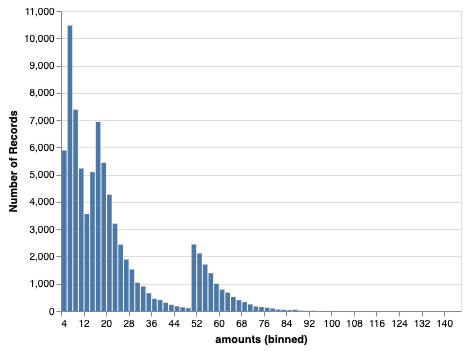

In [10]:
import pandas as pd

import altair as alt
alt.renderers.enable('notebook')
alt.data_transformers.enable('json')

amt = nd_transaction_amounts([5, 15, 50], [0.5, 0.35, 0.15])
amounts = [next(amt) for i in range(80000)]

source = pd.DataFrame({"amounts": amounts})

alt.Chart(source).mark_bar().encode(
    alt.X("amounts", bin=alt.Bin(maxbins=100)),
    y='count()'
)

We can also plot a broader distribution of transactions:

CPU times: user 212 ms, sys: 8.08 ms, total: 221 ms
Wall time: 480 ms


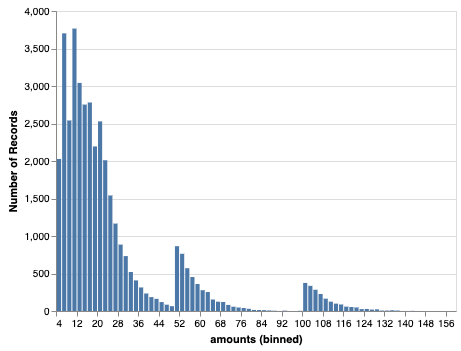

In [11]:
%%time
amt = nd_transaction_amounts([5, 10, 15, 20, 50, 100], 
                          [0.35, 0.25, 0.15, 0.1, 0.1, 0.05])
amounts = [next(amt) for i in range(40000)]

source = pd.DataFrame({"amounts": amounts})

alt.Chart(source).mark_bar().encode(
    alt.X("amounts", bin=alt.Bin(maxbins=100)),
    y='count()',
)

Let's make that transaction-amount generator deterministic.

In [12]:
import time

def transaction_amounts(means, percentages, seed=None):
    def mkgamma(m, rng):
        while True:
            yield from stats.gamma.ppf(rng.uniform(size=1024), a=1.1, scale=min(m, 750), loc=m)
    
    if seed is None:
        seed = int(time.time()) & ((1 << 32) - 1)
        
    prng = np.random.RandomState(seed)
    
    distributions = [mkgamma(m * 100, prng) for m in means]
    
    while True:
        streams = [next(d) for d in distributions]
        yield (np.floor(np.choose(prng.choice(len(means), p=percentages), streams)) / 100)

Finally, we'll sanity-check the deterministic version to make sure it behaves the same way as the non-determinstic version.

CPU times: user 2.5 s, sys: 31.9 ms, total: 2.54 s
Wall time: 3.42 s


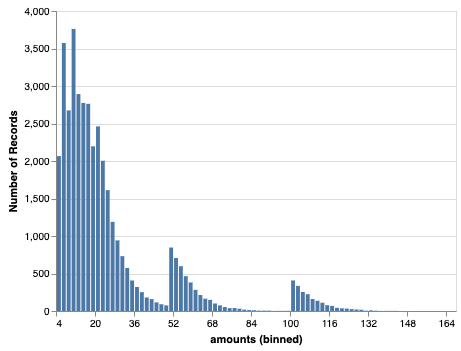

In [13]:
%%time

amt = transaction_amounts([5, 10, 15, 20, 50, 100], 
                          [0.35, 0.25, 0.15, 0.1, 0.1, 0.05],
                          seed=0x12341234)
amounts = [next(amt) for i in range(40000)]

source = pd.DataFrame({"amounts": amounts})

alt.Chart(source).mark_bar().interactive().encode(
    alt.X("amounts", bin=alt.Bin(maxbins=100)),
    y='count()',
)

Next up, we'll make a generator to create the entry types.  

You may have noticed that we need to do some extra work at the beginning of each generator function to make it deterministic -- specifically, something like this:

    if seed is None:
        seed = int(time.time()) & ((1 << 32) - 1)
    
    prng = np.random.RandomState(seed)
    
This code sets up a pseudorandom number generator, either seeded with an explicit value (if supplied) or with the time (if no seed is supplied).  We shouldn't be writing this code more than once, so let's set up some code to automatically add this to every function that will need its own seeded PRNG.  We'll use Python's [decorator](https://www.python.org/dev/peps/pep-0318/) facility for this purpose.

In [14]:
def makeprng(func):
    import time
    def call_with_prng(*args, prng=None, seed=None, **kwargs):
        if prng is None:
            if seed is None:
                seed = int(time.time()) & ((1 << 32) - 1)
            prng = np.random.RandomState(seed)
        return func(*args, prng=prng, seed=seed, **kwargs)
    return call_with_prng

Here's our decorator in action:

In [15]:
@makeprng
def legitimate_entry_types(prng=None, seed=None):    
    entry_types = ["contactless", "chip_and_pin", "swipe", "manual", "online"]
    entry_probs = [0.25,0.2,0.15,0.05,0.35]

    while True:
        yield entry_types[prng.choice(len(entry_types), p=entry_probs)]

We'll also declare a simple function to make it easy to generate an instance of a SciPy distribution class with a given seed:

In [16]:
def makedist(dist_cls, seed=None, prng=None, **kwargs):
    d = dist_cls(**kwargs)
    d.random_state = (seed and seed) or prng.randint((1 << 32) - 1)
    return d

...and one for selecting merchants (primarily a user's favorite merchants):

In [17]:
@makeprng
def merchant_stream(common_merchants, all_merchants, fav_percentage=0.2, probs=[0.6,0.37,0.03], prng = None, seed=None):
    favorite_merchants = prng.choice(common_merchants,
                                          size=int(len(common_merchants) * fav_percentage))
    merchants = [favorite_merchants, common_merchants, all_merchants]
    while True:
        pool = merchants[prng.choice(len(merchants), p=probs)]
        yield int(prng.choice(pool))

We can combine all of these to generate a stream of legitimate activity for a single user:

In [18]:
@makeprng
def legitimate_user_stream(user_id, transactions_per_day=12, start_timestamp=0, amount_means=[20,100,500], amount_probs=[0.9,0.075,0.025], prng=None, seed=None, common_merchants=None, merchant_count=20000):
    if common_merchants is None:
        # this case means that "common" merchants are unique to each user
        common_merchants = prng.choice(merchant_count, size=merchant_count // 21)
    
    amounts = transaction_amounts(amount_means, amount_probs, seed=prng.randint((1<<32)-1))
    entry_types = legitimate_entry_types(seed=prng.randint((1<<32)-1))
    merchants = merchant_stream(common_merchants, np.arange(merchant_count), seed=prng.randint((1<<32)-1))
    
    SECONDS_PER_DAY = 86400
    SECONDS_PER_HOUR = 60 * 60
    loc = SECONDS_PER_DAY // transactions_per_day
    p = 1 / (loc / 10)
    
    geom = makedist(stats.geom, prng=prng, p=p, loc=loc)
    
    # choose an arbitrary timezone offset (in seconds)
    tz_offset = (user_id % 24) * SECONDS_PER_HOUR
    WAKEUP_TIME = 7 * SECONDS_PER_HOUR
    SLEEP_TIME = 21 * SECONDS_PER_HOUR
    
    ts = start_timestamp
    snooze = False
    
    while True:
        amount = next(amounts)
        entry = next(entry_types)
        foreign = entry == "online" and prng.choice([True, False], p=[0.4, 0.6])
        
        merchant_id = next(merchants)
        
        offset = geom.rvs()
        
        localtime = (ts + tz_offset) % SECONDS_PER_DAY
        if localtime < WAKEUP_TIME or localtime > SLEEP_TIME:
            snooze = True
        
        while snooze:
            localtime = (ts + tz_offset + offset) % SECONDS_PER_DAY
            if localtime > WAKEUP_TIME and localtime < SLEEP_TIME:
                snooze = False
            offset += geom.rvs()
            
        result = {
            "user_id": user_id,
            "amount": amount,
            "merchant_id": merchant_id,
            "entry": entry,
            "foreign": foreign
        }
        ts = yield (offset, ("legitimate", *result.values()))
        

In [19]:
sim = simulate([legitimate_user_stream(i, common_merchants=common_merchants) for i in [1,6,9,14]])

for i in range(200):
    if i < 10 or i > 190:
        print(next(sim))
    elif i == 10:
        print("...")

(7686, ('legitimate', 9, 24.98, 14207, 'contactless', False))
(7686, ('legitimate', 14, 24.98, 14207, 'contactless', False))
(16569, ('legitimate', 6, 24.98, 14207, 'contactless', False))
(16569, ('legitimate', 9, 23.79, 9462, 'contactless', False))
(16569, ('legitimate', 14, 23.79, 9462, 'contactless', False))
(26806, ('legitimate', 6, 23.79, 9462, 'contactless', False))
(26806, ('legitimate', 9, 102.08, 1674, 'contactless', False))
(26806, ('legitimate', 14, 102.08, 1674, 'contactless', False))
(34133, ('legitimate', 1, 24.98, 14207, 'contactless', False))
(34133, ('legitimate', 6, 102.08, 1674, 'contactless', False))
...
(34133, ('legitimate', 9, 27.9, 6314, 'online', False))
(41877, ('legitimate', 1, 23.79, 9462, 'contactless', False))
(41877, ('legitimate', 6, 27.9, 6314, 'online', False))
(41877, ('legitimate', 9, 24.98, 16397, 'chip_and_pin', False))
(49463, ('legitimate', 1, 102.08, 1674, 'contactless', False))
(49463, ('legitimate', 6, 24.98, 16397, 'chip_and_pin', False))
(49

We can visualize the behavior of users in each time zone to see when they're awake:

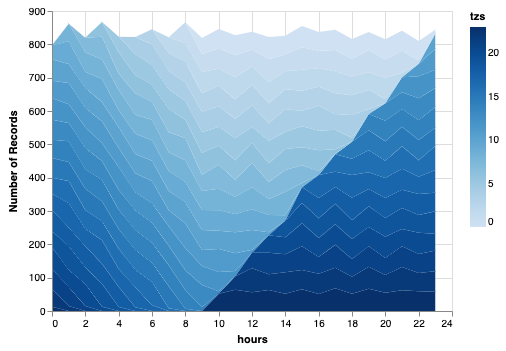

In [20]:
prng = np.random.RandomState(0xcfe1a77e)
seeds = prng.randint((1<<32) - 1, size=24)

sim = simulate([legitimate_user_stream(i, seed=seeds[i]) for i in range(24)])

results = [(offset, tup[1]) for offset, tup in [next(sim) for _ in range(20000)]]
    
source = pd.DataFrame({"hours": [(t[0] % 86400) // 3600 for t in results], 
                       "tzs": [t[1] % 24 for t in results]})

alt.Chart(source).mark_area().encode(
    alt.X("hours"),
    y='count()', color="tzs"
).interactive()

## Simulating fraud

We'll start with some basic assumptions:  

1. fraudulent transactions are equally likely to happen at any arbitrary merchant,
2. fraudulent transactions are typically for small dollar amounts,
3. fraudulent transactions are rare overall, but when they occur, several will occur close together,
4. fraudulent transactions are far more likely to be certain entry types (manual or online) or foreign transactions, and
5. fraudulent transactions occur without regard for the user's typical schedule.

These will guide our design of a fraudulent transaction generator.  We'll simulate parallel and independent streams of legitimate and fraudulent transactions for each user.

In [21]:
@makeprng
def fraud_entry_types(prng=None, seed=None):
    entry_types = ["contactless", "chip_and_pin", "swipe", "manual", "online"]
    entry_probs = [0.05,0.05,0.05,0.35,0.5]

    while True:
        yield entry_types[prng.choice(len(entry_types), p=entry_probs)]
        
@makeprng
def fraudulent_user_stream(user_id, transactions_per_day = 12, transactions_per_burst=10, amount_means=[5,10,20], amount_probs=[0.2, 0.2, 0.6], prng=None, seed=None, merchant_count=20000):
    amounts = transaction_amounts(amount_means, amount_probs, seed=prng.randint((1<<32) - 1))
    entry_types = fraud_entry_types(seed=prng.randint((1<<32) - 1))
    
    SECONDS_PER_DAY = 86400
    loc = SECONDS_PER_DAY // (transactions_per_day * transactions_per_burst)
    p = 1 / 10

    poisson = makedist(stats.poisson, prng=prng, mu=transactions_per_burst)
    foldnorm = makedist(stats.foldnorm, prng=prng, c=1.8, loc=SECONDS_PER_DAY * 30, scale=1 << 20)
    geom = makedist(stats.geom, prng=prng, p=p, loc=loc)
    while True:
        # consider also np.floor(stats.gamma.rvs(a=6.4, loc=SECONDS_PER_DAY * 90, scale=SECONDS_PER_DAY, size=1))
        fraud_delay = np.floor(foldnorm.rvs())
        fraud_delay = max(int(fraud_delay), 1)
        
        fraud_count = max(poisson.rvs(), 1)
        
        ams = [next(amounts) for _ in range(fraud_count)]
        ens = [next(entry_types) for _ in range(fraud_count)]
        fs = prng.choice([True, False], p=[0.3, 0.7], size=fraud_count)
        
        m_ids = prng.choice(merchant_count, size=fraud_count)
        offsets = geom.rvs(size=fraud_count)
        offsets[0] += fraud_delay
        
        for offset, amount, merchant_id, entry, foreign in zip(offsets, ams, m_ids, ens, fs):
            result = {
                "user_id": user_id,
                "amount": amount,
                "merchant_id": merchant_id,
                "entry": entry,
                "foreign": foreign
            }
            yield (offset, ("fraud", *result.values()))

Let's sanity-check the output of our fraudulent transaction generator.

In [22]:
sim = simulate([fraudulent_user_stream(1, seed=123, merchant_count=MERCHANT_COUNT), 
                fraudulent_user_stream(2, seed=456, merchant_count=MERCHANT_COUNT), 
                fraudulent_user_stream(3, seed=789, merchant_count=MERCHANT_COUNT)])

for i in range(200):
    v = next(sim)
    if i < 10 or i > 190:
        print(v)
    elif i == 10:
        print("...")

(3680412, ('fraud', 2, 22.83, 834, 'manual', False))
(3681133, ('fraud', 2, 14.47, 3947, 'manual', True))
(3681854, ('fraud', 2, 15.64, 9320, 'manual', True))
(3682592, ('fraud', 2, 27.75, 2564, 'online', False))
(3683367, ('fraud', 2, 22.29, 15624, 'online', True))
(3684096, ('fraud', 2, 17.03, 6462, 'online', False))
(3684820, ('fraud', 2, 11.55, 10598, 'manual', True))
(3685541, ('fraud', 2, 31.09, 6416, 'manual', False))
(3686283, ('fraud', 2, 20.74, 15148, 'online', False))
(3687012, ('fraud', 2, 8.91, 5618, 'online', False))
...
(30566045, ('fraud', 1, 21.56, 18115, 'online', False))
(30566769, ('fraud', 1, 26.65, 18059, 'manual', True))
(30567507, ('fraud', 1, 20.95, 10332, 'online', False))
(33425130, ('fraud', 3, 20.35, 5101, 'online', False))
(33425863, ('fraud', 3, 30.15, 18944, 'manual', False))
(33426598, ('fraud', 3, 28.38, 4614, 'swipe', False))
(33427329, ('fraud', 3, 23.11, 3631, 'manual', False))
(33428062, ('fraud', 3, 31.46, 1338, 'online', False))
(33428789, ('frau

In [23]:
sim = simulate([legitimate_user_stream(1, seed=123, common_merchants=common_merchants, merchant_count=MERCHANT_COUNT), 
                legitimate_user_stream(2, seed=456, common_merchants=common_merchants, merchant_count=MERCHANT_COUNT), 
                legitimate_user_stream(3, seed=789, common_merchants=common_merchants, merchant_count=MERCHANT_COUNT),
                fraudulent_user_stream(1, seed=321, merchant_count=MERCHANT_COUNT), 
                fraudulent_user_stream(2, seed=654, merchant_count=MERCHANT_COUNT), 
                fraudulent_user_stream(3, seed=987, merchant_count=MERCHANT_COUNT)])
count = 0
STEPS = 50000

for i in range(STEPS):
    result = next(sim)
    if result[1][0] == 'fraud':
        count += 1

print("%.02f%% of transactions were fraudulent" % (count / STEPS * 100))

2.89% of transactions were fraudulent


# Generating a file of synthetic transactions



In [24]:
import time
import itertools

def setup(user_count = 10000, merchant_count = 20000, common_fraction = 21, seed = None):
    # a small percentage of merchants account for most transactions
    common_merchant_count = merchant_count // common_fraction
    prng = np.random.RandomState(seed or 0xda7aba5e)

    common_merchants = prng.choice(merchant_count,
                                   size=common_merchant_count,
                                   replace=True)

    legitimate_user_seeds = prng.randint(1<<32, size=user_count)
    fraud_user_seeds = prng.randint(1<<32, size=user_count)
    
    legitimate_streams = [legitimate_user_stream(uid, seed=seed, transactions_per_day=5 + prng.randint(13),
                                                 common_merchants=common_merchants, 
                                                 merchant_count=merchant_count,
                                                 amount_means=[3 * (prng.randint(7) + 1), 
                                                               5 * (prng.randint(20) + 4), 
                                                               20 * (prng.randint(35) + 4)]) 
                          for uid, seed in enumerate(legitimate_user_seeds)]
    fraud_streams = [fraudulent_user_stream(uid, seed=seed, merchant_count=merchant_count) 
                     for uid, seed in enumerate(fraud_user_seeds) if prng.randint(10) < 6]
    print("%d legitimate users and %d fraud streams" % (len(legitimate_streams), len(fraud_streams)))
    return simulate(itertools.chain(legitimate_streams, fraud_streams), initial_time=int(time.time()))

In [25]:
simulation = setup(seed=0x20200213)

with open("fraud.csv", "w") as f:
    f.write("timestamp,label,user_id,amount,merchant_id,trans_type,foreign\n")
    for i in range(50000000):
        v = next(simulation)
        f.write(("%d," % v[0]) + ",".join([str(val) for val in v[1]]) + "\n")

10000 legitimate users and 5954 fraud streams


IndexError: index 0 is out of bounds for axis 0 with size 0